# Implementing GAN with Keras: 
### To generate fake but real looking images of hand written digits using MNIST dataset.

In [1]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

   GAN proposed by Ian J. Goodfellow et al., in 2014 is generative model that is capable of generating synthetic images from noise input that look very similer to real dataset on which GAN is trained but these generated are not real. GAN are called as adversarial nets because it contains two models within it namely generator and discriminator which work adversarial to each other and learn to generate truely synthetic images.
   Generative model G is deep convolution neural network having certain number of layers according to resolution of required output from it and our source data image size. It is inputed with random noise and and output images exactly of same dimensions of our image data images are generated from it. This output along with real images is fed to discriminator in GAN network.      Discriminator (D) is another deep convolution neural network that learns predicting whether input image is from real data or it is image from generator's output. Discriminator and generator are compiled in one network called GAN with loss function such as binary crossentropy in most basic implementations of GANs and optimization algorithms such as Schocastic gradient descent or Adam. A specific way of training is followed by which because of adversarial relationship between generator and discriminator, with every epoch both generator and discriminator gets better at generating real looking but fake images and identifying image whether it is real or came fron generator's output. 

<img src="GAN.png" width="600" height="350" />   


In this assignment I have implemented a very basic GAN considering computational limitation to train CNN on my system to generate realistic looking hand written digits from random noise input to GAN. Training is done on images of hand written digits of MNIST dataset.

## 1: Importing Libraries and Helper Functions:

Some helper functions are defined to generate relevant plots in tfutils.py attached with this submission.


In [2]:
%matplotlib notebook

import tensorflow as tf
import numpy as np
import os
import tfutils

from matplotlib import pyplot as plt
from tensorflow.keras.layers import Dense, Flatten, Conv2D, BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose, Reshape, LeakyReLU
from tensorflow.keras.models import Model, Sequential
from PIL import Image

print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.5.0


## 2: Importing and Plotting the Data:
MNIST  dataset is imported using helper function defined in tfutils.

In [3]:
(x_train, y_train), (x_test, y_test) = tfutils.datasets.mnist.load_data(one_hot=False)


In [4]:
# Explore your dataset 
m_train = x_train.shape[0]
num_px = np.sqrt(x_train.shape[1])
m_test = x_test.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("x_train shape: " + str(x_train.shape))
print ("y_train shape: " + str(y_train.shape))
print ("x_test shape: " + str(x_test.shape))
print ("y_test shape: " + str(y_test.shape))

Number of training examples: 60000
Number of testing examples: 10000
x_train shape: (60000, 784)
y_train shape: (60000,)
x_test shape: (10000, 784)
y_test shape: (10000,)


Thus we have total 60000 images and 10000 images in training and testing set of hand written numbers from 0 to 9.
For this assignment, I am ignoring all the other digits data except zero and using only data of 0 to train GAN. This data is filtered and stored in x by following function.

In [5]:
x_train = tfutils.datasets.mnist.load_subset([0], x_train, y_train)
x_test = tfutils.datasets.mnist.load_subset([0], x_test, y_test)

x = np.concatenate([x_train, x_test], axis=0)

In [6]:
print ("x shape: " + str(x.shape))

x shape: (6903, 784)


10 random images from this data are displayed as follows:

<IPython.core.display.Javascript object>


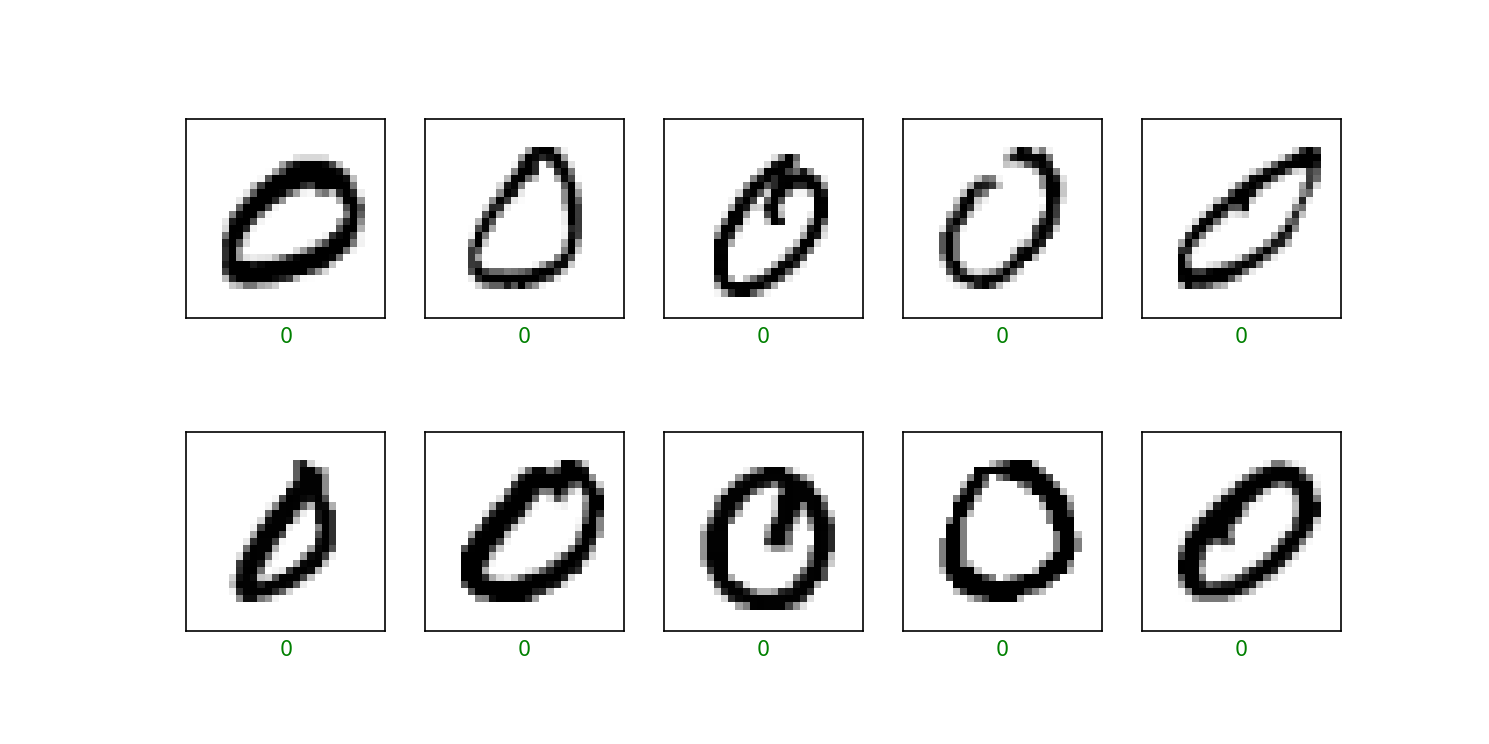

In [7]:
tfutils.datasets.mnist.plot_ten_random_examples(plt, x, np.zeros((x.shape[0], 1))).show()

## 3: Discriminator model:


The discriminator is nothing but a binary classifier that consists of several convolution layers that expands feature information reducing width and height of input image in subsequent layers  (like any other image classification task) as we go drrp in convNet. In last conv. layer flattened output is mapped to a classification output that output either 0 for input image from generator or 1 for input image coming from real dataset.


Keras sequential model is used to create this network. Summary shows number of filters, output shape and parameters associated with each layer.

In [8]:
size = 28
noise_dim = 1

discriminator = Sequential([
    Conv2D(64, 3, strides=2, input_shape=(28, 28, 1)),
    LeakyReLU(),
    BatchNormalization(),
    
    Conv2D(128, 5, strides=2),
    LeakyReLU(),
    BatchNormalization(),
    
    Conv2D(256, 5, strides=2),
    LeakyReLU(),
    BatchNormalization(),
    
    Flatten(),
    Dense(1, activation='sigmoid')
])

opt = tf.keras.optimizers.Adam(lr=2e-4, beta_1=0.5)

discriminator.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
discriminator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 13, 13, 64)        640       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 13, 13, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 13, 13, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 5, 128)         204928    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 5, 5, 128)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 5, 5, 128)         512       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 1, 256)         8

C:\Users\Shashank\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


## 4: Generator model:
The generator model perform function of taking random noise as input and generating 28x28x1 image in our case to give it as input to discriminator.It mainly consists of Deconvolution layers or more accurately, Transposed Convolution layers that basically perform the reverse of a Convolution operation and increase image size in susequent layers of network. 


Generator model, after the training,
irrespective of the input, learns all
the features that are required to create images, realistic
images of the handwritten digits zero and with different
values for the input.

In [9]:
generator = Sequential([
    Dense(256, activation='relu', input_shape=(noise_dim,)),
    Reshape((1, 1, 256)),
    
    Conv2DTranspose(256, 5, activation='relu'),
    BatchNormalization(),
    Conv2DTranspose(128, 5, activation='relu'),
    BatchNormalization(),

    Conv2DTranspose(64, 5, strides=2, activation='relu'),
    BatchNormalization(),
    Conv2DTranspose(32, 5, activation='relu'),
    BatchNormalization(),

    Conv2DTranspose(1, 4, activation='sigmoid')

])

generator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               512       
_________________________________________________________________
reshape (Reshape)            (None, 1, 1, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 5, 5, 256)         1638656   
_________________________________________________________________
batch_normalization_3 (Batch (None, 5, 5, 256)         1024      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 9, 9, 128)         819328    
_________________________________________________________________
batch_normalization_4 (Batch (None, 9, 9, 128)         512       
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 21, 21, 64)       

Output of untrained generator is plotted as follows:

<IPython.core.display.Javascript object>


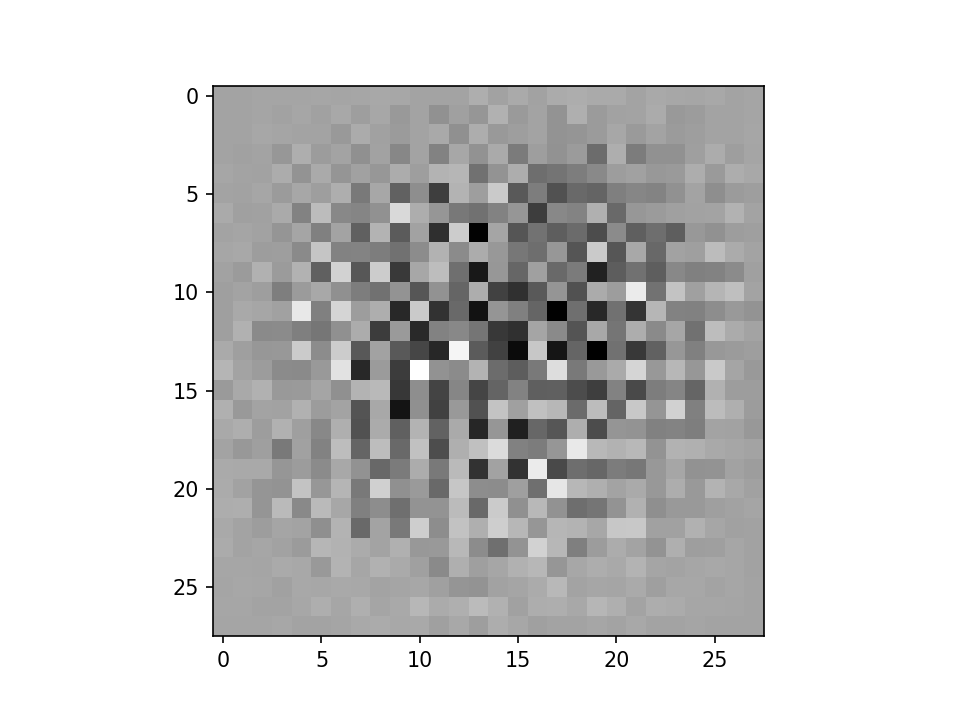

In [10]:
noise = np.random.randn(1, noise_dim)
gen_image = generator.predict(noise)[0]

plt.figure()
plt.imshow(np.reshape(gen_image, (28, 28)), cmap='binary');

## 5: Creating GAN model:
GAN is created by combining generator and discriminator by giving output of generator to discriminator as an input. For GAN model aim is to make generator better in its task of fooling discriminator so that more realistic images similar to training data can be generated. As per the original paper of GAN (Goodfellow et al., 2014) the loss function for GAN model is defined as:


$\mathop{min}_{\textbf{G}} \mathop{max}_{\textbf{D}} V (D,G) = E_{x}[lod(D(x))] + E_{z}[log(1-D(G(z))] $              (1)

Where,
$D_{x}$ is the discriminator's estimate of the probability that real data instance x is real.  
Ex is the expected value over all real data instances.  
$G_{z}$ is the generator's output when given noise z.  
$D(G(z))$ is the discriminator's estimate of the probability that a fake instance is real.  
Ez is the expected value over all random inputs to the generator (in effect, the expected value over all generated fake instances G(z)).  

Above function is nothing but the cross entropy loss on descriminators output on real and generated distributions. Thus while compiling GAN, cross entropy loss function is used in following implementation.

In [11]:
input_layer = tf.keras.layers.Input(shape=(noise_dim,))
gen_out = generator(input_layer)
disc_out = discriminator(gen_out)

gan = Model(
    input_layer,
    disc_out
)

discriminator.trainable = False
gan.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
gan.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 28, 28, 1)         2717025   
_________________________________________________________________
sequential (Sequential)      (None, 1)                 1027073   
Total params: 3,744,098
Trainable params: 2,716,065
Non-trainable params: 1,028,033
_________________________________________________________________


## 6: Training the GAN:

Refer to loss function defined above. We train GAN for D to maximize the probability of assigning the correct label to both training examples and samples from G. We simultaneously train G to minimize log(1 − D(G(z))).  
Looking at loss function we can sense that the generator can't directly affect the log(D(x)) term in the function, so, for the generator, minimizing the loss is equivalent to minimizing log(1 - D(G(z))).  
For discriminator, we want to maximize its accuracy so as not to get fooled by generator thus training steps of GAN can thus be summarized as:      


1) Decide batch size and number of epochs for training.  


2) In each bath of input examples, half of the examples will be from real image data and half will be from generator's output. Considering this calculate number of steps per epoch as:  
  steps per epoch = 2*(number of training examples)/batch size 

3) Sample minibatch of (batch size/2) examples from training data and minibatch of (batch size/2) examples from generator's output by giving random noise as input to generator.  


4) Combine these two sample minibatches to make one mibatch to train discriminator. Train discriminator to minimize its binary cross entropy loss in descriminator model. Minimizing this loss is equivalent to maximizing log(D(x)) term in GAN model loss.

5) Now turn off training of discriminator and train generator to minimize log(1 - D(G(z))) term in GAN loss. Looking at loss function of GAn we can sense that the generator can't directly affect the log(D(x)) term in the function, so training generator is equivalent to training GAn to minimize its loss function by disabling discriminator's training.

6) Repeat these steps by training for multiple epochs to simultaneously update parameters of generator and discriminator at every epoch.  

Following cells implement this training scheme. GAN loss and Discriminator accuracy are plotted along with generators output on inputed random noise at regular intervals during training in following cell.

In [12]:


epochs = 25
batch_size = 128
steps_per_epoch = int(2 * x.shape[0]/batch_size)

print('Steps per epoch=', steps_per_epoch)



Steps per epoch= 107


<IPython.core.display.Javascript object>


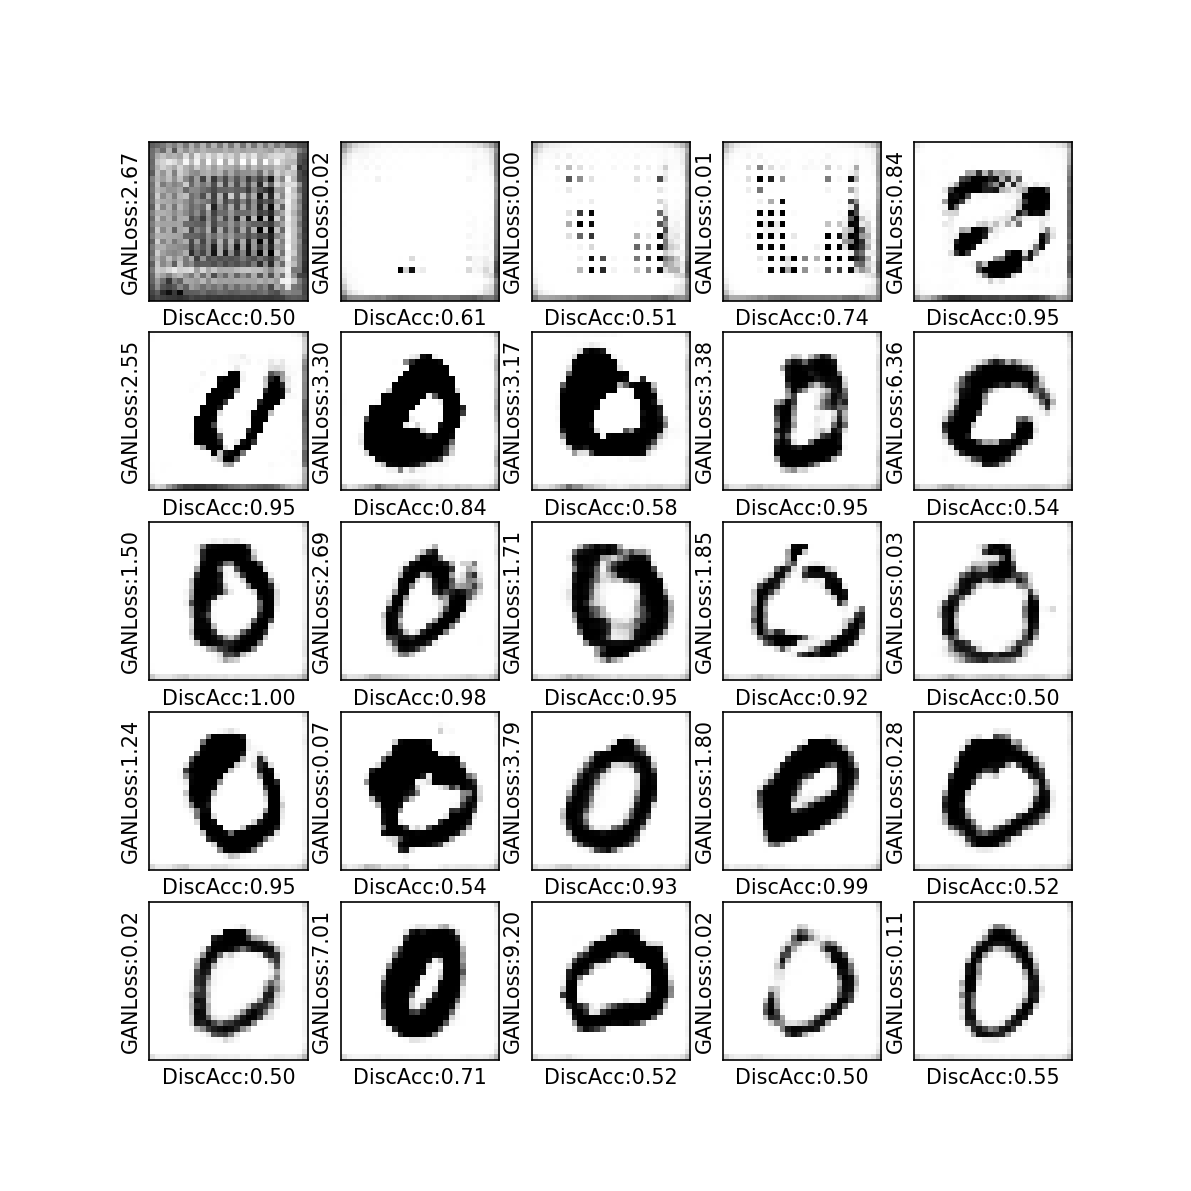

Wall time: 5min 53s


In [13]:
%%time

dp = tfutils.plotting.DynamicPlot(plt, 5, 5, (8, 8))

for e in range(0, epochs):
    
    dp.start_of_epoch(e)
    
    for step in range(0, steps_per_epoch):
        true_examples = x[int(batch_size/2)*step: int(batch_size/2)*(step + 1)]
        true_examples = np.reshape(true_examples, (true_examples.shape[0], 28, 28, 1))

        noise = np.random.randn(int(batch_size/2), noise_dim)
        generated_examples = generator.predict(noise)

        x_batch = np.concatenate([generated_examples, true_examples], axis=0)
        y_batch = np.array([0] * int(batch_size/2) + [1] * int(batch_size/2))

        indices = np.random.choice(range(batch_size), batch_size, replace=False)
        x_batch = x_batch[indices]
        y_batch = y_batch[indices]

        # train the discriminator
        discriminator.trainable = True
        discriminator.train_on_batch(x_batch, y_batch)
        discriminator.trainable = False

        # train the generator
        loss, _ = gan.train_on_batch(noise, np.ones((int(batch_size/2), 1)))

        _, acc = discriminator.evaluate(x_batch, y_batch, verbose=False)

    noise = np.random.randn(1, noise_dim)
    generated_example = generator.predict(noise)[0]
    
    dp.end_of_epoch(np.reshape(generated_example, (28, 28)), 'binary',
                   'DiscAcc:{:.2f}'.format(acc), 'GANLoss:{:.2f}'.format(loss))